In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt



class FlexibleMISEnvironment(gym.Env):
    def __init__(self, adjacency_matrix):
        super(FlexibleMISEnvironment, self).__init__()
        self.adj_matrix = np.array(adjacency_matrix)
        self.num_nodes = len(adjacency_matrix)
        
        # Define action and observation space
        self.action_space = spaces.Discrete(self.num_nodes)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.num_nodes,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_set = set()
        self.available_nodes = set(range(self.num_nodes))
        return self._get_state(), {}  # Return state and info dict

    def step(self, action):
        reward = 0
        terminated = False
        truncated = False
        
        if action in self.available_nodes:
            self.current_set.add(action)
            self.available_nodes -= set([action] + np.where(self.adj_matrix[action] == 1)[0].tolist())
            reward = 1
            terminated = len(self.available_nodes) == 0
        else:
            reward = -1
            terminated = True
        
        return self._get_state(), reward, terminated, truncated, {}  # State, reward, terminated, truncated, info

    def _get_state(self):
        state = np.zeros(self.num_nodes, dtype=np.float32)
        state[list(self.current_set)] = 1
        state[list(self.available_nodes)] = 0.5
        return state

class FlexibleFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 64):
        super(FlexibleFeatureExtractor, self).__init__(observation_space, features_dim=features_dim)
        n_input = observation_space.shape[0]
        self.net = nn.Sequential(
            nn.Linear(n_input, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.net(observations)

def create_ppo_model(env):
    policy_kwargs = dict(
        features_extractor_class=FlexibleFeatureExtractor,
        features_extractor_kwargs=dict(features_dim=64),
    )
    return PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)

def generate_random_graph(num_nodes, edge_probability=0.2):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.random.random() < edge_probability:
                adjacency_matrix[i][j] = adjacency_matrix[j][i] = 1
    return adjacency_matrix.tolist()

def visualize_graph_and_mis(adjacency_matrix, mis):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)
    G.add_nodes_from(range(num_nodes))
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G)

    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
    nx.draw_networkx_labels(G, pos, font_size=8)

    nx.draw_networkx_nodes(G, pos, nodelist=list(mis), node_color='red', node_size=400)

    plt.title("30-Node Graph with Maximum Independent Set (highlighted in red)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def solve_and_visualize_mis(adjacency_matrix, training_steps=10000):
    mis = solve_mis(adjacency_matrix, training_steps)
    print(f"Maximum Independent Set: {mis}")
    visualize_graph_and_mis(adjacency_matrix, mis)

def solve_mis(adjacency_matrix, training_steps=10000):
    # Create and wrap the environment
    env = DummyVecEnv([lambda: FlexibleMISEnvironment(adjacency_matrix)])

    # Create and train the agent
    model = create_ppo_model(env)
    model.learn(total_timesteps=training_steps)

    # Test the trained agent
    obs = env.reset()
    done = False
    mis = set()

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = env.step(action)
        done = dones[0]
        if rewards[0] > 0:
            mis.add(action[0])

    return mis


NameError: name 'torch' is not defined

Solving and visualizing small graph:
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 7669 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 4207       |
|    iterations           | 2          |
|    time_elapsed         | 0          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03940372 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.59      |
|    explained_variance   | 0.0555     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.354      |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0645    |
|    value_loss           | 0.906      |
---------------------------------------

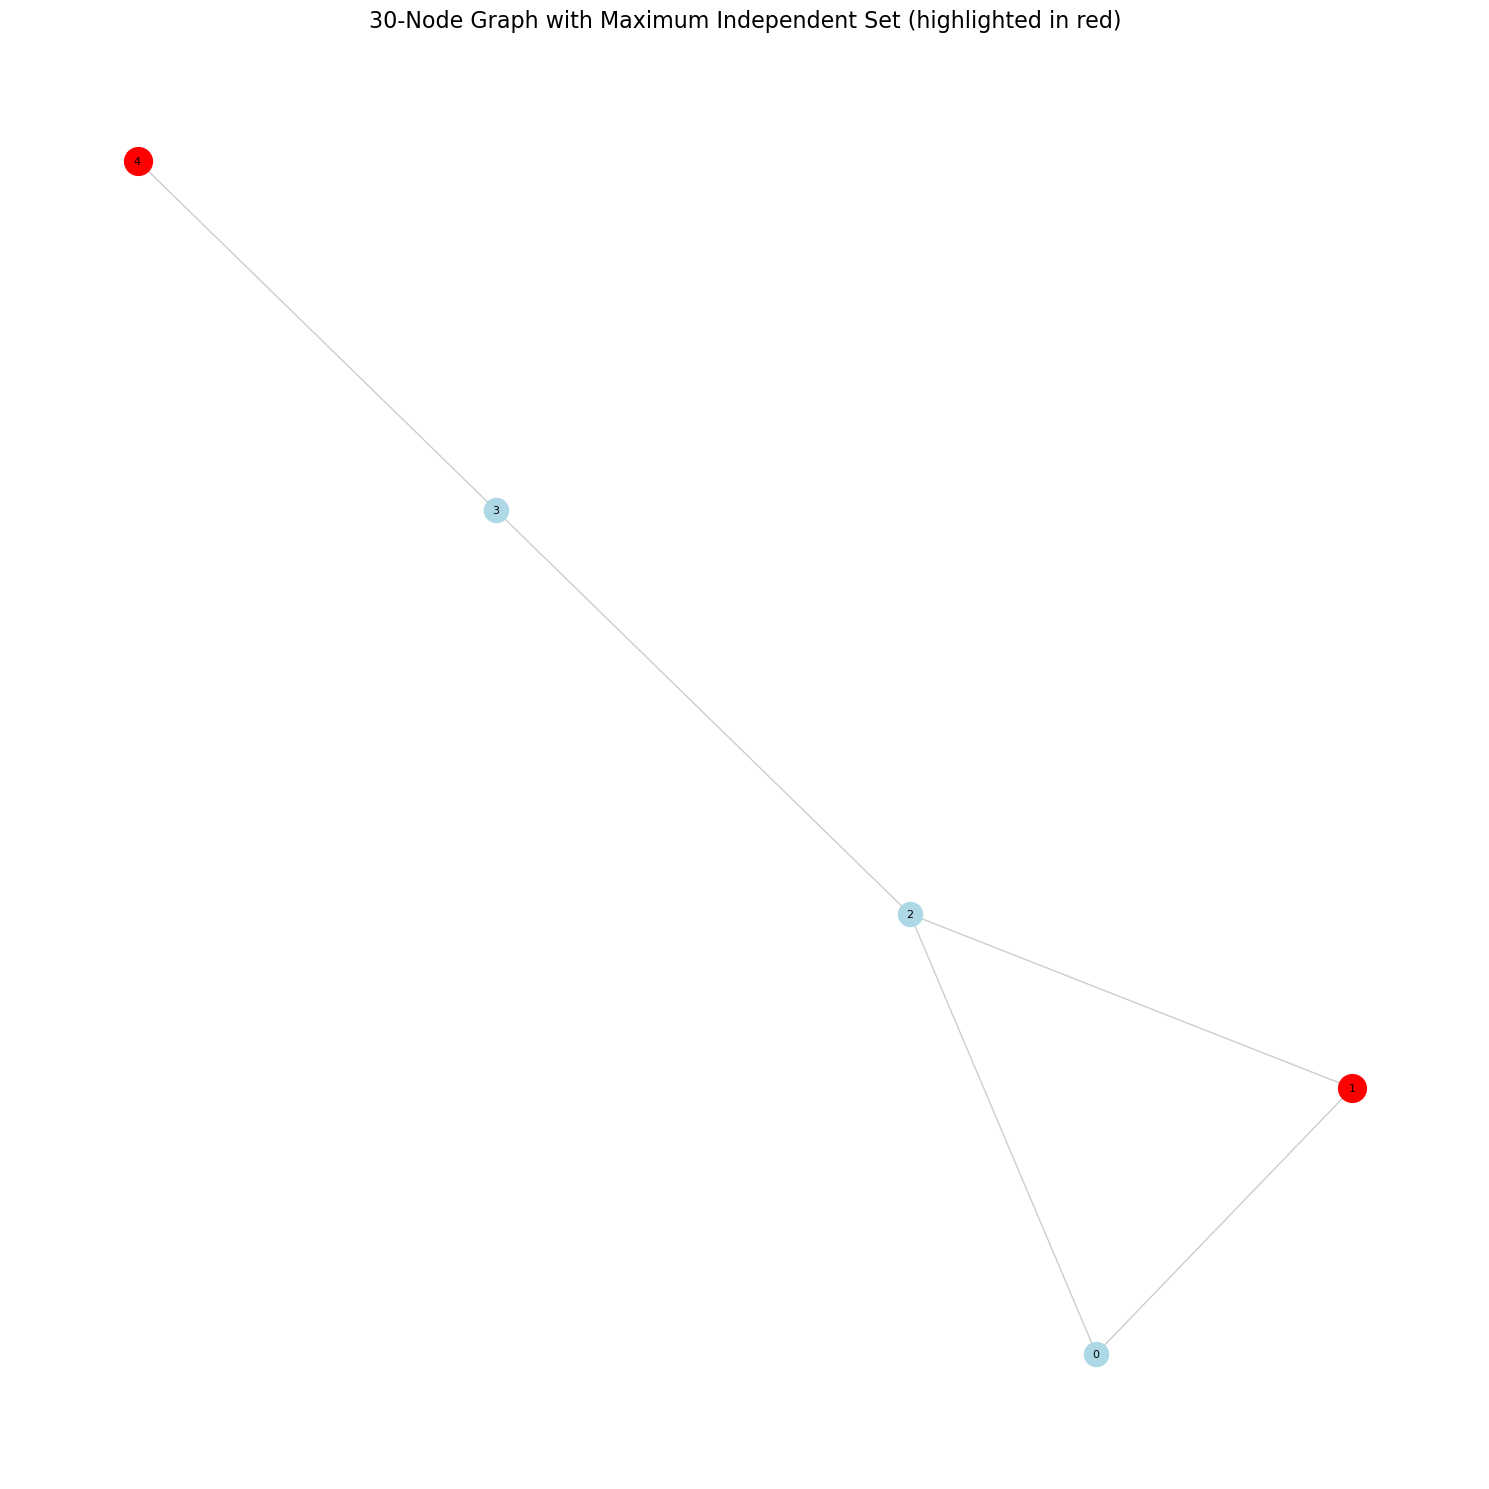

In [ ]:

# Example usage
small_graph = [
    [0, 1, 1, 0, 0],
    [1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [0, 0, 0, 1, 0]
]
print("Solving and visualizing small graph:")
solve_and_visualize_mis(small_graph)



Solving and visualizing larger graph:
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 7691 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4211        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019447675 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.00267     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.351       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0345     |
|    value_loss           | 0.805       |
--------------------

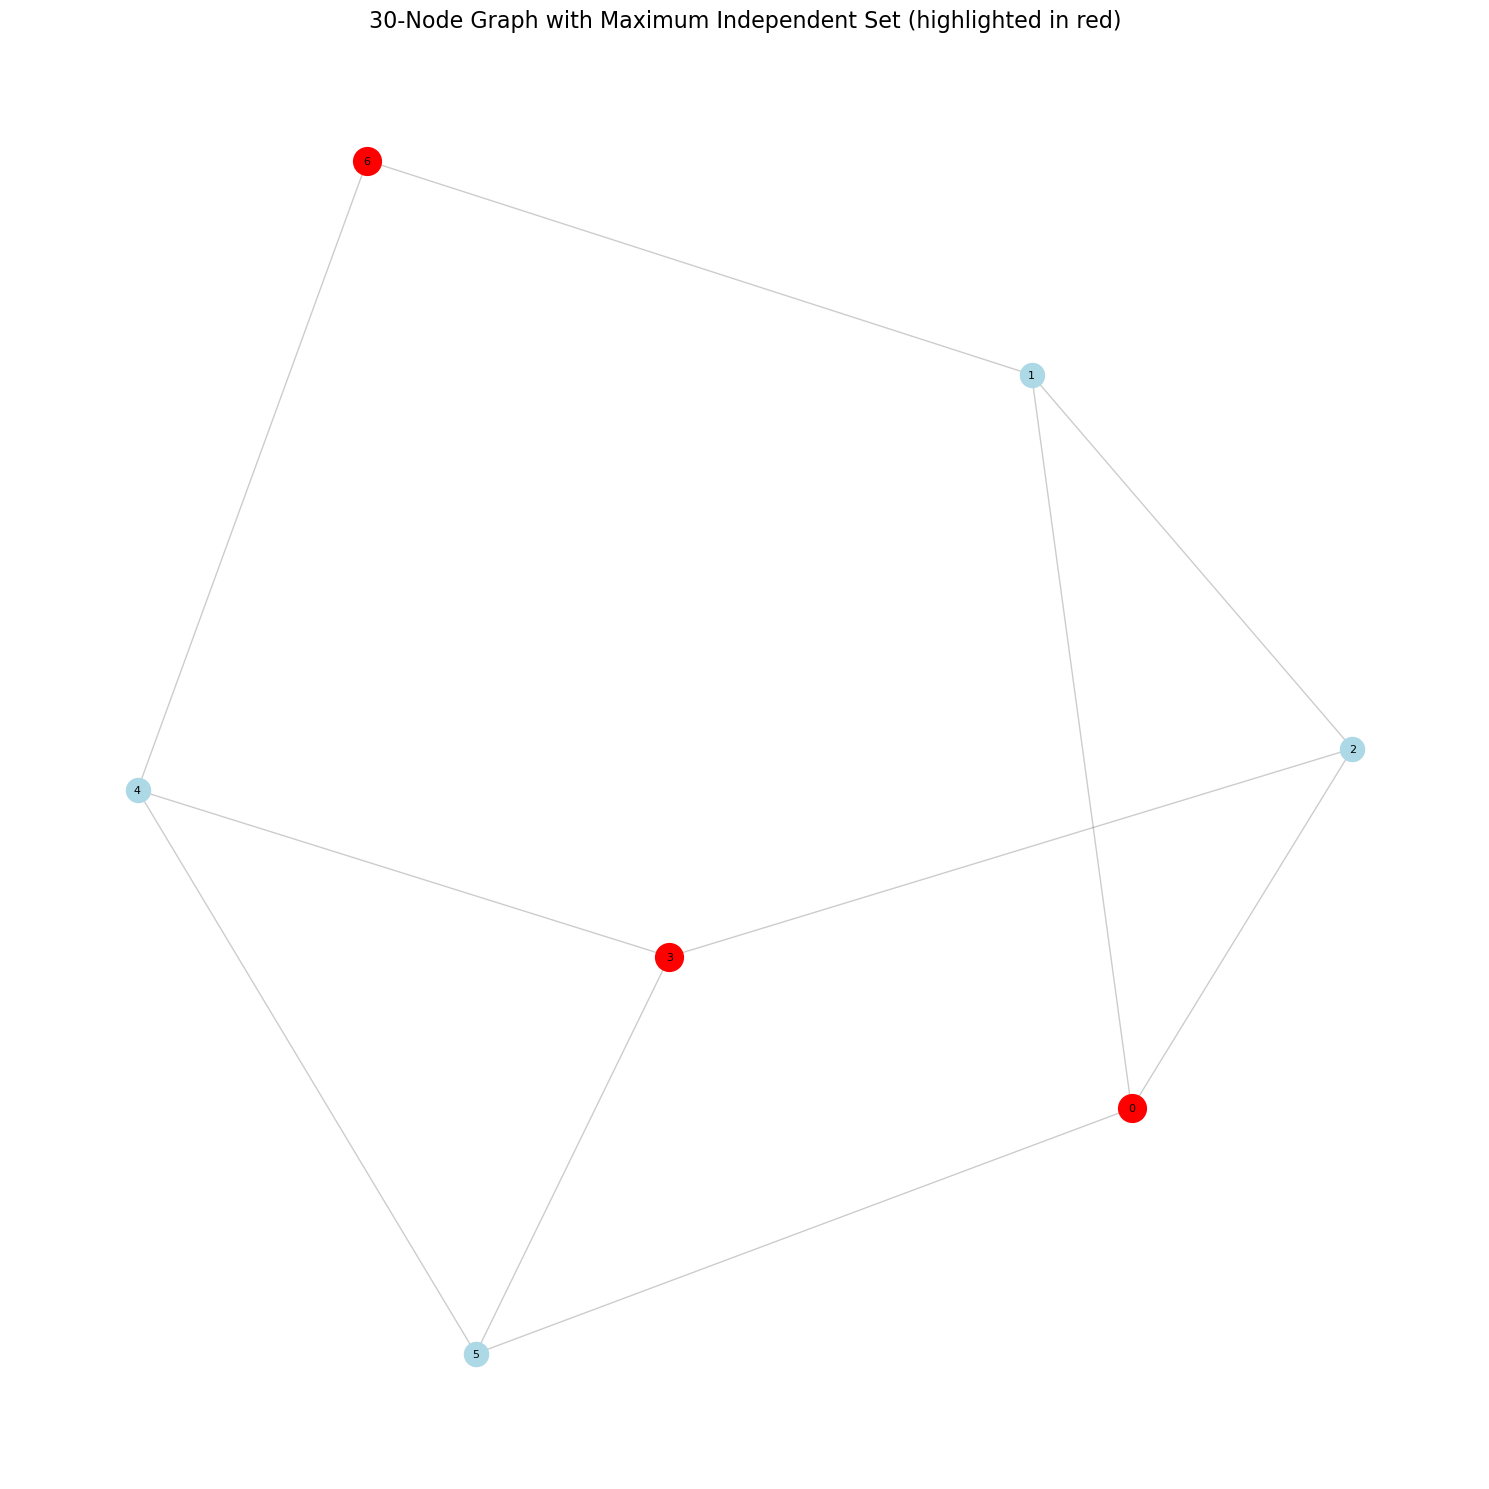

In [ ]:
larger_graph = [
    [0, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1, 1],
    [1, 0, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0]
]

print("\nSolving and visualizing larger graph:")
solve_and_visualize_mis(larger_graph, training_steps=20000)


Solving and visualizing 30-node graph:
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 7623 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4060        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015631936 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.39       |
|    explained_variance   | -0.115      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.434       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0324     |
|    value_loss           | 1.16        |
--------------------

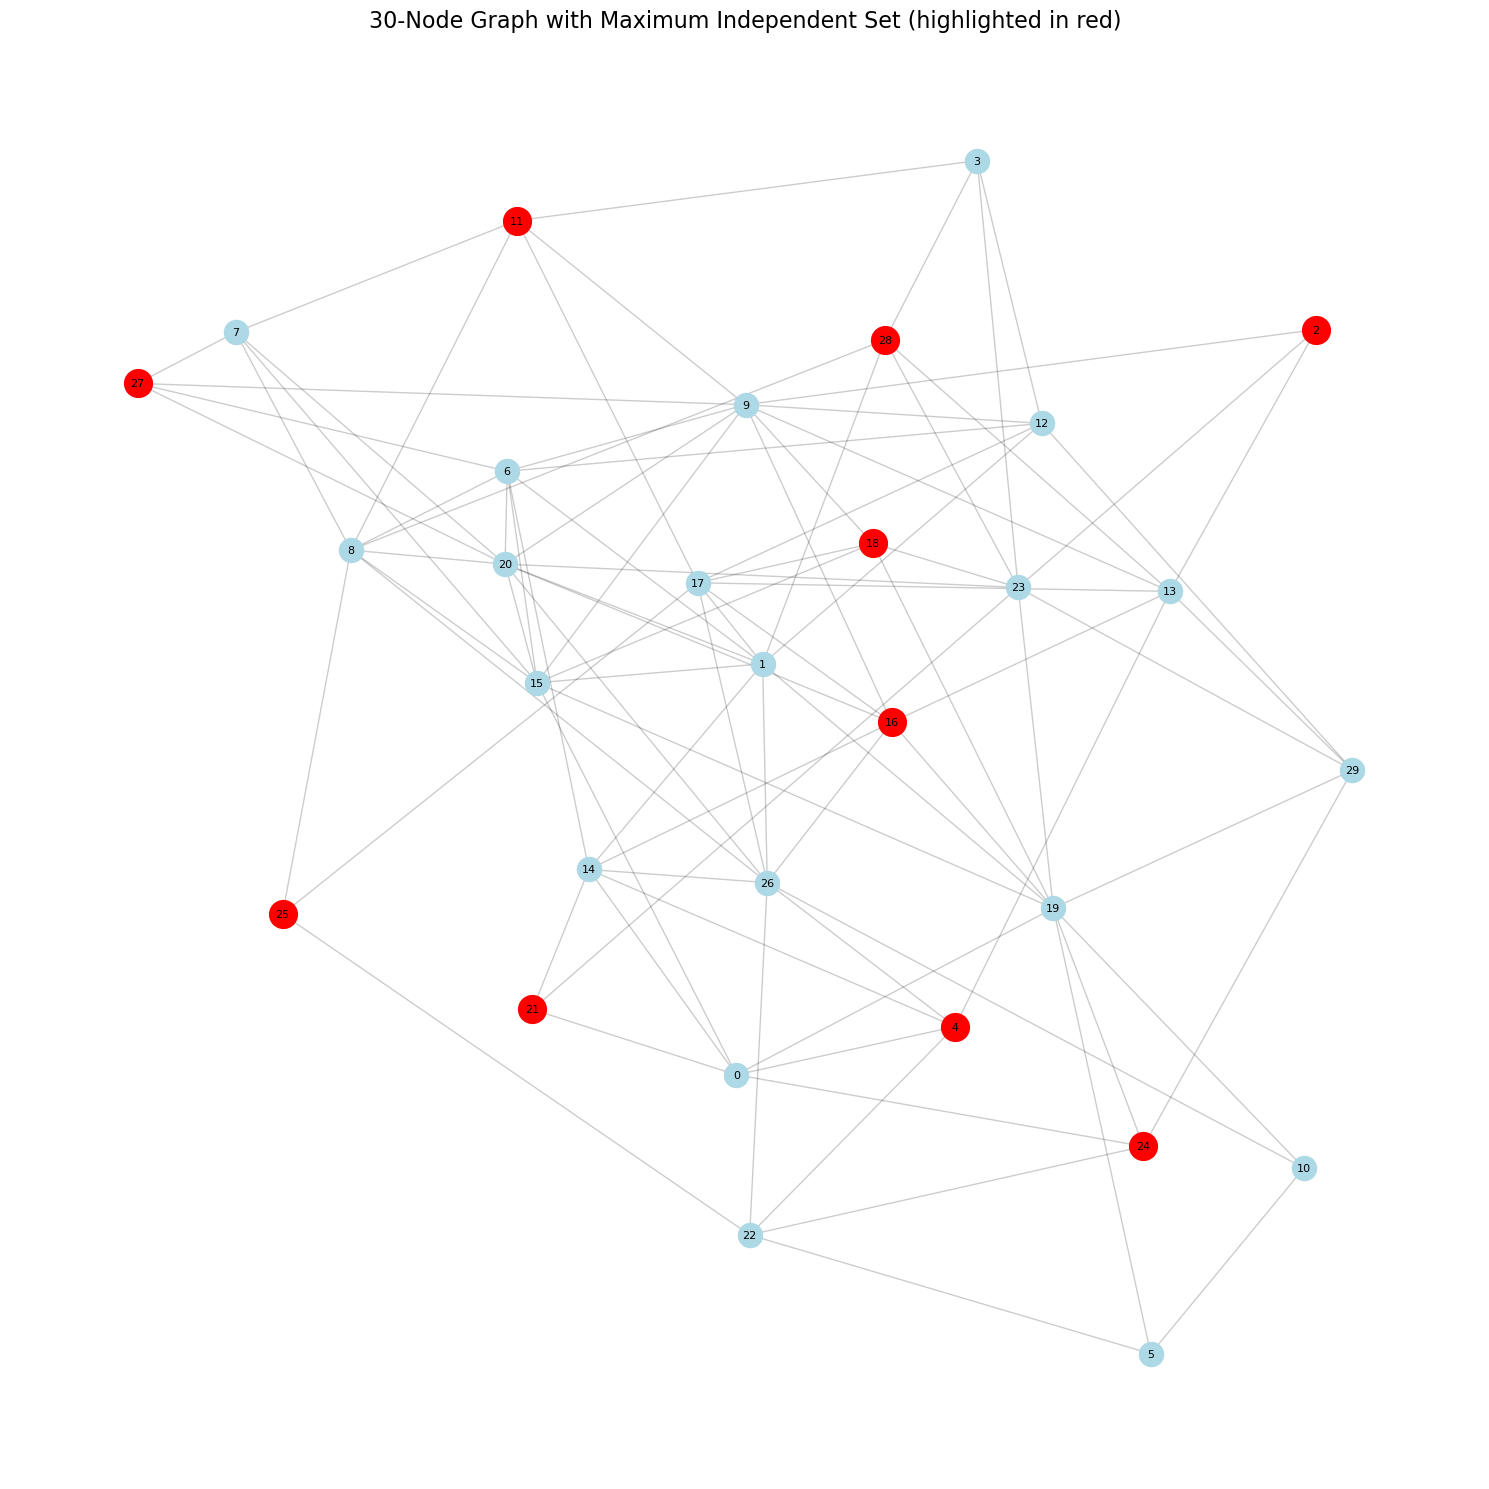

In [ ]:
# Generate a random 30-node graph
num_nodes = 30
random_graph = generate_random_graph(num_nodes)

print("Solving and visualizing 30-node graph:")
solve_and_visualize_mis(random_graph, training_steps=50000)

In [ ]:
# # Generate a random 30-node graph
# num_nodes = 1000
# random_graph = generate_random_graph(num_nodes)

# print("Solving and visualizing 30-node graph:")
# solve_and_visualize_mis(random_graph, training_steps=50000*2)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_graph_from_adjacency_matrix(adjacency_matrix, title="Graph from Adjacency Matrix"):
    # Create a graph
    G = nx.Graph()
    
    # Add edges based on the adjacency matrix
    num_nodes = len(adjacency_matrix)
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Only upper triangle to avoid duplicates
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Use spring layout for node positioning
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Draw the graph
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    # Set title
    plt.title(f"{title}\n{num_nodes} nodes, {G.number_of_edges()} edges", fontsize=16)
    
    # Remove axis
    plt.axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

    return G

